In [1]:
import ROOT
import uproot
import math
import time
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import pandas as pd
import os
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import TensorDataset, DataLoader
import dgl
from dgl.nn import EdgeGATConv
from dgl.nn import EdgeGATConv, GATConv, GraphConv, SumPooling, AvgPooling, MaxPooling
from dgl.dataloading import GraphDataLoader
from dgl import DGLGraph
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
random_state = 42
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

def plot_binned(x, y, num_bins=30, color="blue", label=None):
    """Plot mean y in bins of x."""
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, bin_means, marker="o", linestyle="None", color=color, label=label)

Welcome to JupyROOT 6.30/04


/data_ilc/flc/shi/miniconda3/envs/DGL/lib/python3.10/site-packages/ROOT/_facade.py:154: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  return _orig_ihook(name, *args, **kwds)


In [2]:
# 打开 ROOT 文件，载入 events tree
Threshold=0.5*0.1328
#MIP=(0.0410,0.0861,0.1328,0.1803,0.2282)# for Si 0.15mm,0.3mm,0.45mm,0.6mm,0.75mm. Unit is MeV
ECAL_layers=30
def ReadData_Energy(DataPath,ParticleEnergy,precision=0.01):
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    Z_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for i_E in range(len(ParticleEnergy)):
    #for i_E in range(0,1):
        input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
        E_layers,N_layers,Z_layers,E_truth = ReadRoot(input_file_name)
        E_layers_all = np.vstack((E_layers_all, np.vstack(E_layers)))
        N_layers_all = np.vstack((N_layers_all, np.vstack(N_layers)))
        Z_layers_all = np.vstack((Z_layers_all, np.vstack(Z_layers)))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
        E_truth_all = np.round(E_truth_all/precision)*precision
    return E_layers_all, N_layers_all, Z_layers_all, E_truth_all
def ReadData_Uniform(DataPath):
    root_files = [os.path.join(DataPath, f) for f in os.listdir(DataPath) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    Z_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for input_file in root_files:
        E_layers, N_layers, Z_layers, E_truth = ReadRoot(input_file)
        E_layers_all = np.vstack((E_layers_all, E_layers))
        N_layers_all = np.vstack((N_layers_all, N_layers))
        Z_layers_all = np.vstack((Z_layers_all, Z_layers))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, Z_layers_all, E_truth_all
def ReadRoot(input_file_name):
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    E_truth = tree["MCParticles.p0"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    calo_layer = cellID & 0x7F
    num_events = len(energy)
    E_layers = []
    N_layers = []
    Z_layers = []
    for i_event in range(num_events):
        # convert to numpy arrays
        layers = calo_layer[i_event].to_numpy()
        energies = energy[i_event].to_numpy()
        posZ = pos_z[i_event].to_numpy()
        Z_layers_event = np.bincount(layers, weights=posZ*energies, minlength=ECAL_layers)
        E_layers_event = np.bincount(layers, weights=energies, minlength=ECAL_layers)
        N_layers_event = np.bincount(layers, minlength=ECAL_layers)
        Z_layers.append(Z_layers_event/E_layers_event.clip(min=1e-6))
        E_layers.append(E_layers_event)
        N_layers.append(N_layers_event)
    E_truth_flat = ak.to_numpy(ak.flatten(E_truth, axis=None))
    return E_layers,N_layers,Z_layers,E_truth_flat
#Read Data
DataPath_Validate="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Train="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Uniform="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/Uniform"
Energy_Train=(0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,15.0,25.0,35.0,45.0,55.0,65.0)
Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)#add 0.1 0.25 after all data is ready
#E_layers_train, N_layers_train, E_truth_train = ReadData_Energy(DataPath_Train,Energy_Train)
E_layers_test, N_layers_test, Z_layers_test, E_truth_test = ReadData_Energy(DataPath_Validate,Energy_test)
E_layers_uniform, N_layers_uniform, Z_layers_uniform, E_truth_uniform = ReadData_Uniform(DataPath_Uniform)

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.1GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.25GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/1.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/2.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/5.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_la

length after zero suppression: 1249703 1249703 1249703 1249703 1249703 1249703
length after event selection: 1249703
length after zero suppression: 59990 59990 59990 59990 59990 59990
length after event selection: 59990
length of E_truth_test: 59990


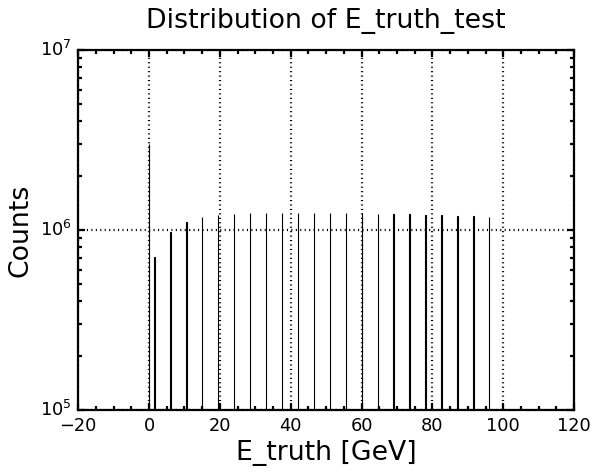

length after event selection: 59990 59990 59990 59990 59990 59990


In [3]:
#zero suppression
def zero_suppression(E_layers, N_layers, Z_layers, E_truth):
    N_sum = np.array([np.sum(n) for n in N_layers])
    E_sum = np.array([np.sum(e) for e in E_layers])
    Z_sum = np.array([np.sum(z) for z in Z_layers])
    E_truth = np.array(E_truth)

    mask = N_sum > 0
    E_layers_filtered = [E_layers[i] for i in range(len(E_layers)) if mask[i]]
    N_layers_filtered = [N_layers[i] for i in range(len(N_layers)) if mask[i]]
    Z_layers_filtered = [Z_layers[i] for i in range(len(Z_layers)) if mask[i]]
    E_truth_filtered = E_truth[mask]
    E_sum_filtered = E_sum[mask]
    N_sum_filtered = N_sum[mask]

    print("length after zero suppression:", len(E_layers_filtered), len(N_layers_filtered), len(E_sum_filtered), len(N_sum_filtered), len(Z_layers_filtered), len(E_truth_filtered))
    return E_layers_filtered, N_layers_filtered, E_sum_filtered, N_sum_filtered, Z_layers_filtered, E_truth_filtered

#Start from shower layer
def start_from_shower_layer(arr):
    N = len(arr)
    nonzero_idx = np.argmax(arr != 0)
    trimmed = arr[nonzero_idx:]
    if len(trimmed) < N:
        trimmed = np.pad(trimmed, (0, N - len(trimmed)), 'constant')
    return trimmed

def Event_Selection(E_layers,N_layers,Z_layers,E_truth):
    E_layers, N_layers, E_sum, N_sum, Z_layers, E_truth = zero_suppression(E_layers, N_layers, Z_layers, E_truth)
    E_layers = np.array([start_from_shower_layer(ev) for ev in E_layers])
    N_layers = np.array([start_from_shower_layer(ev) for ev in N_layers])
    Z_layers = np.array([start_from_shower_layer(ev) for ev in Z_layers])
    print("length after event selection:", len(E_layers))
    return E_layers, N_layers, E_sum, N_sum, Z_layers, E_truth

#E_layers_train, N_layers_train, E_sum_train, N_sum_train, E_truth_train = Event_Selection(E_layers_train, N_layers_train, E_truth_train)
E_layers_uniform, N_layers_uniform, E_sum_uniform, N_sum_uniform, Z_layers_uniform, E_truth_uniform = Event_Selection(E_layers_uniform, N_layers_uniform, Z_layers_uniform, E_truth_uniform)
E_layers_test, N_layers_test, E_sum_test, N_sum_test, Z_layers_test, E_truth_test = Event_Selection(E_layers_test, N_layers_test, Z_layers_test, E_truth_test)
#Draw E_truth
print("length of E_truth_test:", len(E_truth_test))
plt.figure(figsize=fig_size)
plt.hist(Z_layers_uniform.flatten(), bins=1000, range=(0, 100), edgecolor="black")
#plt.hist(E_truth_test, bins=20, range=(0, 1), edgecolor="black")
plt.xlabel("E_truth [GeV]")
plt.ylabel("Counts")
plt.yscale("log")
plt.title("Distribution of E_truth_test")
plt.grid(True)
plt.show()
print("length after event selection:", len(E_layers_test), len(N_layers_test), len(E_sum_test), len(N_sum_test), len(Z_layers_test), len(E_truth_test))

In [4]:
E_layers_uniform_ratio = E_layers_uniform / (E_sum_uniform[:, np.newaxis])
N_layers_uniform_ratio = N_layers_uniform / (N_sum_uniform[:, np.newaxis])
E_layers_test_ratio    = E_layers_test / (E_sum_test[:, np.newaxis])
N_layers_test_ratio    = N_layers_test / (N_sum_test[:, np.newaxis])
#performance not good
# E_layers_uniform_exp = np.exp(E_layers_uniform_ratio)
# N_layers_uniform_exp = np.exp(N_layers_uniform_ratio)
# E_layers_test_exp    = np.exp(E_layers_test_ratio)
# N_layers_test_exp    = np.exp(N_layers_test_ratio)

E_N_layers_uniform =  E_layers_uniform/(N_layers_uniform+1e-6)
E_N_layers_test    =  E_layers_test/(N_layers_test+1e-6)
#EN_layers_uniform = E_N_layers_uniform * N_layers_uniform
#EN_layers_test    = E_N_layers_test * N_layers_test

LayerNum_uniform = np.array([np.sum(e>0) for e in E_layers_uniform])
LayerNum_test    = np.array([np.sum(e>0) for e in E_layers_test])
Average_E_layer_uniform = E_sum_uniform / (LayerNum_uniform + 1e-6) 
Average_E_layer_test    = E_sum_test / (LayerNum_test + 1e-6)
Average_N_layer_uniform = N_sum_uniform / (LayerNum_uniform + 1e-6)
Average_N_layer_test    = N_sum_test / (LayerNum_test + 1e-6)

In [5]:
def ScaleFeatures(Features_train, Features_test):
    scaler = StandardScaler().fit(Features_train)
    Features_train_scaled = scaler.transform(Features_train)
    Features_test_scaled  = scaler.transform(Features_test)
    return Features_train_scaled, Features_test_scaled

E_layers_uniform_scaled, E_layers_test_scaled = ScaleFeatures(E_layers_uniform, E_layers_test)
N_layers_uniform_scaled, N_layers_test_scaled = ScaleFeatures(N_layers_uniform, N_layers_test)
Z_layers_uniform_scaled, Z_layers_test_scaled = ScaleFeatures(Z_layers_uniform, Z_layers_test)
E_N_layers_uniform_scaled, E_N_layers_test_scaled = ScaleFeatures(E_N_layers_uniform, E_N_layers_test)

extra_features_train = np.hstack([
    E_layers_uniform,
    N_layers_uniform,
    E_layers_uniform_ratio,
    E_sum_uniform[:, np.newaxis],
    N_layers_uniform_ratio,
    N_sum_uniform[:, np.newaxis],
    E_N_layers_uniform,
    #LayerNum_uniform,
    #Average_E_layer_uniform,
    #Average_N_layer_uniform
])

extra_features_test = np.hstack([
    E_layers_test,
    N_layers_test,
    E_layers_test_ratio,
    E_sum_test[:, np.newaxis],
    N_layers_test_ratio,
    N_sum_test[:, np.newaxis],
    E_N_layers_test,
    #LayerNum_test,
    #Average_E_layer_test,
    #Average_N_layer_test
])
extra_features_train, extra_features_test = ScaleFeatures(extra_features_train, extra_features_test)

In [6]:
def make_event_graph_list(conv_features, pos_features, y_true, extra_features=None, k=3):
    n_events, n_nodes = conv_features.shape[:2]
    data_list = []

    conv_features = torch.tensor(conv_features, dtype=torch.float32)
    pos_features  = torch.tensor(pos_features, dtype=torch.float32)
    y_true        = torch.tensor(y_true, dtype=torch.float32)
    if extra_features is not None:
        extra_features = torch.tensor(extra_features, dtype=torch.float32)

    for i in tqdm(range(n_events), desc="Constructing graphs"):
        x_conv = conv_features[i]  # (n_nodes, conv_dim)
        pos    = pos_features[i]   # (n_nodes,) or (n_nodes, pos_dim)
        x = torch.cat([x_conv, pos], dim=-1)  # (n_nodes, conv_dim + pos_dim)
        g = dgl.knn_graph(pos, k=k)
        g.ndata['feat'] = x
        g.graph_attr = {'y': y_true[i]}
        if extra_features is not None:
            g.ndata['extra'] = extra_features[i].unsqueeze(0)
        data_list.append(g)
    return data_list



def get_batch_size(device):
    if device.type == "cuda":
        total_mem = torch.cuda.get_device_properties(device).total_memory / (1024**3)  # GB
        if total_mem < 8:
            return 256
        elif total_mem < 16:
            return 1024
        else:
            return 2048
    else:
        return 128
conv_features_train = np.stack([E_layers_uniform_scaled, N_layers_uniform_scaled, E_N_layers_uniform_scaled], axis=-1)
pos_features_train = Z_layers_uniform_scaled[..., np.newaxis]
conv_features_test = np.stack([E_layers_test_scaled, N_layers_test_scaled, E_N_layers_test_scaled], axis=-1)
pos_features_test = Z_layers_test_scaled[..., np.newaxis]
conv_dim = conv_features_train.shape[-1]
pos_dim = pos_features_train.shape[-1]
print("shape:", conv_features_train.shape, pos_features_train.shape, extra_features_train.shape)
print("conv dim:", conv_dim, "pos dim:", pos_dim)
y_train_true = E_truth_uniform
y_test_true = E_truth_test
KNN_K=8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = get_batch_size(device)
batch_size = 4096 # for llrui02
print("Using device:", device, "with batch size:", batch_size)
data_list_train = make_event_graph_list(
    conv_features=conv_features_train,
    pos_features=pos_features_train,
    y_true=y_train_true,
    extra_features=None,
    k=KNN_K,
)

data_list_test  = make_event_graph_list(
    conv_features=conv_features_test,
    pos_features=pos_features_test,
    y_true=y_test_true,
    extra_features=None,
    k=KNN_K,
)
val_split = 0.2
data_list_train, data_list_val = train_test_split(data_list_train, test_size=val_split, random_state=random_state)


shape: (1249703, 30, 3) (1249703, 30, 1) (1249703, 152)
conv dim: 3 pos dim: 1
Using device: cuda with batch size: 4096


Constructing graphs: 100%|██████████| 59990/59990 [00:14<00:00, 4201.71it/s]


In [ ]:
class RelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        return torch.mean(rel**2)
class RelativeMSELoss_Power3(nn.Module):
    def __init__(self, eps=1e-8, power=3):
        super().__init__()
        self.eps = eps
        self.power = power
    def forward(self, y_pred, y_true):
        out = ((y_pred - y_true)**2) / ((y_true + self.eps)**self.power)
        return torch.mean(out)   
class HuberRelativeLoss(nn.Module):
    def __init__(self, delta=0.1, eps=1e-8):
        super().__init__()
        self.delta = delta
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        abs_rel = torch.abs(rel)
        #Basic
        loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, self.delta * (abs_rel - 0.5*self.delta))
        #Test
        #loss = torch.where(square < 0.01, 0.5 * rel**3, self.delta * (abs_rel - 0.5*self.delta))
        return torch.mean(loss)
class ResidualLinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1, activation=None):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation if activation is not None else nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = x
        #out = self.activation(out)
        out = self.linear(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out
    
#General MLP with residual blocks, no need for input dim
class MLPRegressor(nn.Module):
    def __init__(self, hidden_dims=[128, 64, 32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.inferred_input_dim = None
        print(f"Hidden dims: {hidden_dims}, Dropout: {dropout}, Activation: {activation}")
        layers = []
        layers.append(nn.Sequential(
            nn.LazyBatchNorm1d(),
            nn.LazyLinear(hidden_dims[0]),
            activation,
            nn.Dropout(dropout)
        ))
        prev_dim = hidden_dims[0]
        for h in hidden_dims[1:]:
            layers.append(ResidualLinearBlock(prev_dim, h, dropout=dropout, activation=activation))
            prev_dim = h

        self.model = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)  # 输出事件预测

    def forward(self, x):
        if self.inferred_input_dim is None:
            self.inferred_input_dim = x.shape[-1]
            print(f"MLP input dim: {self.inferred_input_dim}")
        x = self.model(x)
        # return self.output_layer(x).squeeze(-1)
        return x

class EdgeGATConvLayer(nn.Module):
    def __init__(self, in_feats, num_heads=1, mlp_dims=[32, 32],
                 activation=nn.PReLU(), dropout=0.1):
        super().__init__()
        self.activation = activation
        self.num_heads = num_heads
        self.mlp_dims = mlp_dims
        self.out_feats = mlp_dims[0] // num_heads
        assert self.out_feats * num_heads == mlp_dims[0], \
            "mlp_dims[0] must be divisible by num_heads"
        # EdgeGATConv
        print(f"EdgeGATConvLayer: in_feats={in_feats}, out_feats={self.out_feats}, num_heads={num_heads}, edge_feats={2*in_feats}")
        self.conv = EdgeGATConv(
            in_feats=in_feats,
            out_feats=self.out_feats,
            num_heads=num_heads,
            edge_feats=2 * in_feats,  # x_i || (x_j - x_i)
            feat_drop=dropout,
            attn_drop=dropout,
        )
        self.mlp = MLPRegressor(hidden_dims=mlp_dims[1:], dropout=dropout, activation=activation)
    def forward(self, g, x):
        src, dst = g.edges()
        x_i, x_j = x[src], x[dst]
        edge_feat = torch.cat([x_i, x_j - x_i], dim=-1)  # [E, 2*in_feats]
        h = self.conv(g, x, edge_feat)  # [N, num_heads, out_feats]
        if self.num_heads > 1:
            h = h.flatten(1)  # [N, num_heads*out_feats]
        else:
            h = h.squeeze(1)  # [N, out_feats]
        #h = self.activation(h)
        h = self.mlp(h)  # output [N, mlp_dims[-1]]
        return h
class DGCNN_MLP_DGL(nn.Module):
    def __init__(self, in_feats, EdgeMLP_hidden=[[32,32],[64,64]], mlp_hidden=[128,64,32],
                 num_heads=4, dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.edge_convs = nn.ModuleList()
        self.activation = activation
        prev_feats = in_feats
        for hidden in EdgeMLP_hidden:
            mlp_dims = hidden
            self.edge_convs.append(
                EdgeGATConvLayer(
                    in_feats=prev_feats,
                    num_heads=num_heads,
                    mlp_dims=mlp_dims,
                    activation=activation,
                    dropout=dropout
                )
            )
            prev_feats = mlp_dims[-1]
        self.pool = AvgPooling()
        self.mlp = MLPRegressor(hidden_dims=mlp_hidden, dropout=dropout, activation=activation)
        self.energy_output_layer = nn.Linear(mlp_hidden[-1], 1)

    def forward(self, g):
        x = g.ndata['feat']
        for conv in self.edge_convs:
            x = conv(g, x)
        x = self.pool(g, x)
        if 'extra' in g.ndata:
            extra = dgl.mean_nodes(g, 'extra')  # per-graph average
            x = torch.cat([x, extra], dim=-1)
        out = self.mlp(x)
        out = self.energy_output_layer(out).squeeze(-1)
        return out


In [8]:
def collate_graph_classification(batch):
    batched_graph = dgl.batch(batch)
    labels = torch.tensor([g.graph_attr['y'] for g in batch], dtype=torch.float32)
    batched_graph.y = labels
    return batched_graph


def train_dgcnn(data_list_train,data_list_val,
            activation=nn.Sigmoid(),
            loss=HuberRelativeLoss(),
            EdgeMLP_dims=[64, 128],
              mlp_dims=[128, 64, 32],
              num_heads=4, 
              dropout=0.1, 
              lr=1e-3,
              weight_decay=5e-5, 
              batch_size=4096, 
              epochs=30,
              patience=10,
              val_split=0.2,
              random_state=42):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Using device: {device}")
    print(f"Random state: {random_state}")
    print(f"Training samples: {len(data_list_train)}, Validation samples: {int(len(data_list_val))}")
    print(f"learning rate: {lr}, batch size: {batch_size}, epochs: {epochs}, patience: {patience}")
    print(f"Loss function: {loss}")
    train_loader = DataLoader(data_list_train, batch_size=batch_size, shuffle=True,collate_fn=collate_graph_classification)
    val_loader = DataLoader(data_list_val, batch_size=batch_size, shuffle=False,collate_fn=collate_graph_classification)
    in_feats = data_list_train[0].ndata['feat'].shape[-1]
    # Model
    model = DGCNN_MLP_DGL(
        in_feats=in_feats,
        EdgeMLP_hidden=EdgeMLP_dims,
        mlp_hidden=mlp_dims,
        num_heads=num_heads,
        dropout=dropout,
        activation=activation
    ).to(device)
    
    # Optimizer & Loss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = loss

    warmup_epochs = 5
    base_lr = lr
    min_lr = 1e-5

    def lr_lambda(current_epoch):
        if current_epoch <= warmup_epochs:
            return float(current_epoch + 1) / warmup_epochs
        else:
            progress = 2 * (current_epoch - warmup_epochs) / (epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))  # 范围 0~1
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
    # === Training loop with best model tracking ===
    best_val_loss = float("inf")
    best_state_dict = None
    train_loss_history, val_loss_history, beta_history = [],  [], []
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            y_train_true = batch.y.to(device)
            loss = criterion(pred, y_train_true)
            loss.backward()
            optimizer.step()
            num_graphs = getattr(batch, "num_graphs", len(batch.y))
            train_loss += loss.item() * num_graphs
        scheduler.step()
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred = model(batch)
                y_val_true = batch.y.to(device)
                loss = criterion(pred, y_val_true)
                num_graphs = getattr(batch, "num_graphs", len(batch.y))
                val_loss += loss.item() * num_graphs

        train_loss /= len(train_loader.dataset)
        val_loss   /= len(val_loader.dataset)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}| LR: {scheduler.get_last_lr()[0]:.6f} | patience: {patience_counter}")

        # Nan stopping
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("NaN encountered. Stopping training.")
            break
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            if (best_val_loss - val_loss) / best_val_loss > 0.01:
                patience_counter = 0
            best_val_loss = val_loss
            best_state_dict = model.state_dict()    
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    # Restore best model
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    
    plt.figure(figsize=fig_size)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    model.eval()
    y_val_true, y_val_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred = model(batch)
            y_val_true.append(batch.y.cpu())
            y_val_pred.append(pred.cpu())
    y_val_true = torch.cat(y_val_true, dim=0).numpy()
    y_val_pred = torch.cat(y_val_pred, dim=0).numpy()
    return model,y_val_true, y_val_pred

Using device: cuda
Random state: 42
Training samples: 999762, Validation samples: 249941
learning rate: 0.0005, batch size: 4096, epochs: 50, patience: 10
Loss function: HuberRelativeLoss()
EdgeGATConvLayer: in_feats=4, out_feats=8, num_heads=4, edge_feats=8
Hidden dims: [32, 32], Dropout: 0.1, Activation: PReLU(num_parameters=1)
EdgeGATConvLayer: in_feats=32, out_feats=16, num_heads=4, edge_feats=64
Hidden dims: [64, 64], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Hidden dims: [128, 64, 32], Dropout: 0.1, Activation: PReLU(num_parameters=1)
MLP input dim: 32
MLP input dim: 64
MLP input dim: 64
Epoch 001/50 | Train Loss: 0.042643 | Val Loss: 0.034363| LR: 0.000200 | patience: 0
Epoch 002/50 | Train Loss: 0.016853 | Val Loss: 0.008725| LR: 0.000300 | patience: 0
Epoch 003/50 | Train Loss: 0.006343 | Val Loss: 0.008663| LR: 0.000400 | patience: 0
Epoch 004/50 | Train Loss: 0.005187 | Val Loss: 0.008298| LR: 0.000500 | patience: 0
Epoch 005/50 | Train Loss: 0.004644 | Val Loss: 0.0

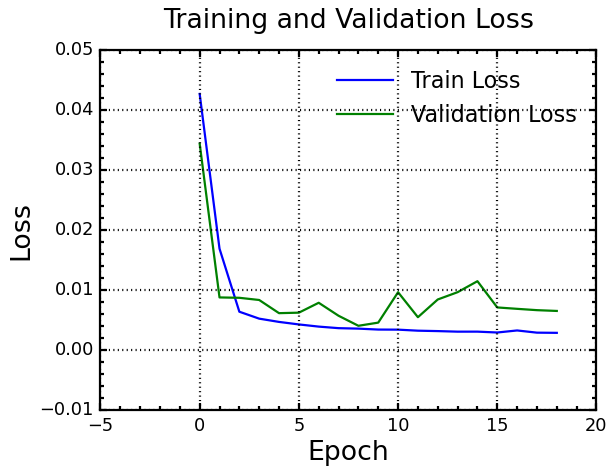

In [ ]:
dgcnn_model, y_val_true, y_val_pred = train_dgcnn(
    data_list_train,
    data_list_val,
    activation=nn.PReLU(),#Try ReLU(),
    loss=HuberRelativeLoss(delta=0.15),
    EdgeMLP_dims=[[32,32,32],[64,64,64]],
    mlp_dims=[128, 64, 32],
    num_heads=4,
    dropout=0.1,
    lr=5e-4,
    weight_decay=5e-5,
    batch_size=batch_size,
    epochs=50,
    patience=10,
    val_split=0.2,
    random_state=random_state
)
torch.save(dgcnn_model, DataPath_Validate+f"/Models/DGCNN.pth")
# Evaluate on test set

Step 1 Linear fit coeffs: [-0.00262783  0.12784603]


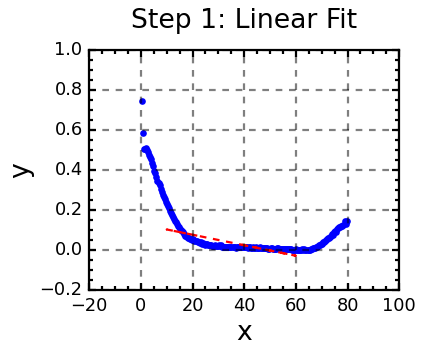

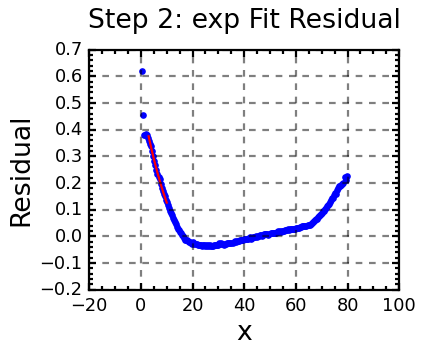

Step 3 Linear fit coeffs: [-0.00262475  0.12782516]


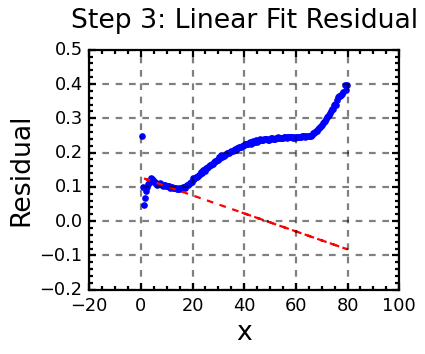

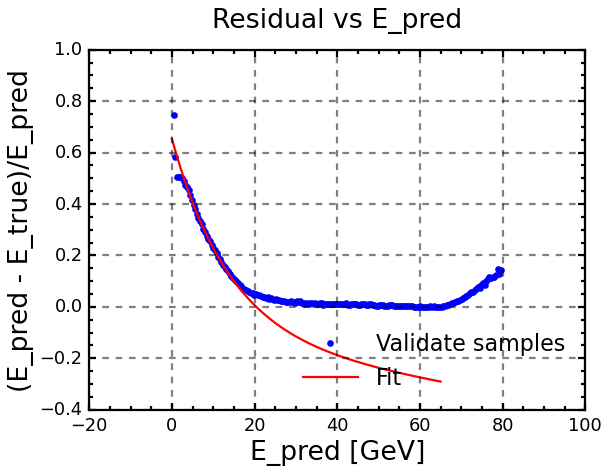

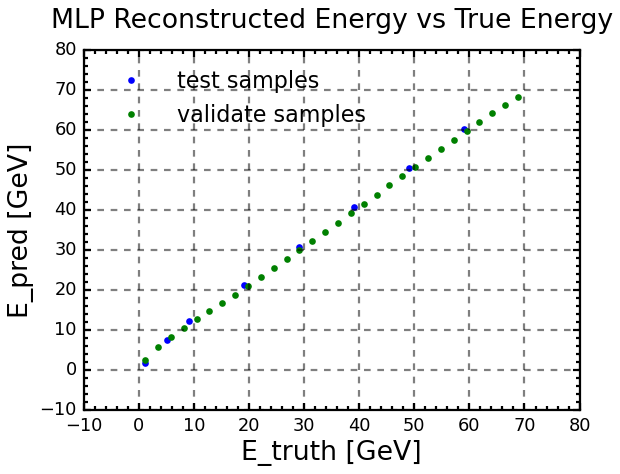

In [10]:
def Combined_fit(x, y, fit_range=(0,65), plot=True, num_bins=100):
    #Step 1: Linear
    linear_range = (10,60)
    mask_lin = (x > linear_range[0]) & (x < linear_range[1])
    coeffs_lin = np.polyfit(x[mask_lin], y[mask_lin], 1)
    y_lin = np.poly1d(coeffs_lin)(x)
    residual = y - y_lin
    print("Step 1 Linear fit coeffs:", coeffs_lin)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, y, num_bins=num_bins, color="blue", label="Data (bin mean)")
        plt.plot(x[mask_lin], y_lin[mask_lin], color="red", linestyle="--", label="Step1: Linear")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Step 1: Linear Fit")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Step 2: exp fit
    #residual = y
    fit_range = (3, 10)
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    def fit_func2(x, a, b, c):
        return a * np.exp(b * x) + c
    coeff_fit2, _ = curve_fit(fit_func2, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    x_fit2 = np.linspace(fit_range[0], fit_range[1], 200)
    y_fit2 = fit_func2(x_fit2, *coeff_fit2)
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
        plt.plot(x_fit2, y_fit2, color="red", linestyle="-", label="Step2: exp Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 2: exp Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

    residual = y - fit_func2(x, *coeff_fit2)

    # Step 4: Linear again
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    params_lin2 = np.polyfit(x[mask_fit], residual[mask_fit], 1)
    y_lin2 = np.poly1d(params_lin2)(x)
    print("Step 3 Linear fit coeffs:", params_lin2)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual after Step2 (bin mean)")
        plt.plot(x, y_lin2, color="red", linestyle="--", label="Step3: Linear Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 3: Linear Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Final combined function
    def f(x_val):
        return ( 
                fit_func2(x_val, *coeff_fit2) + 
                #fit_func3(x_val, *coeff_fit3) + 
                np.poly1d(params_lin2)(x_val))
    return f
def build_reco_hist(y_pred, y_truth, Energy_test, Nbins=50):
    reco_hist = []
    for i_E, E_truth in enumerate(Energy_test):
        mask = (y_truth == E_truth)
        reco_energy = y_pred[mask]

        if len(reco_energy) == 0:
            print(f"No events found for E_truth = {E_truth} GeV, skipping.")
            continue

        mean = np.mean(reco_energy)
        rms = np.std(reco_energy)
        valid_mask = (reco_energy >= mean - 5*rms) & (reco_energy <= mean + 5*rms)

        filtered_data = reco_energy[valid_mask]
        counts, bin_edges = np.histogram(filtered_data, bins=Nbins)

        reco_hist.append({
            "E_truth": E_truth,
            "counts": counts,
            "bin_edges": bin_edges
        })
    return reco_hist

Reco_hist_all = []

device = next(dgcnn_model.parameters()).device
dgcnn_model.eval()
test_loader = DataLoader(data_list_test, batch_size=batch_size, shuffle=False,collate_fn=collate_graph_classification)
y_test_true, y_test_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred = dgcnn_model(batch)
        y_test_true.append(batch.y.cpu())
        y_test_pred.append(pred.cpu())
y_test_true = torch.cat(y_test_true, dim=0).numpy()
y_test_pred = torch.cat(y_test_pred, dim=0).numpy()

Reco_hist_all.clear()
Reco_hist = build_reco_hist(y_test_pred, E_truth_test, Energy_test, Nbins=50)
Reco_hist_all.append(Reco_hist)

fit_range = (0, 65) 
mask = y_val_pred>0
residual_E = (y_val_pred[mask] - y_val_true[mask]) / y_val_pred[mask]
E_calib_fit = Combined_fit(y_val_pred[mask], residual_E, fit_range=fit_range, plot=True, num_bins=200)
x_fit = np.linspace(fit_range[0], fit_range[1], 200)
y_fit = E_calib_fit(x_fit)
plt.figure(figsize=fig_size)
plot_binned(y_val_pred[mask], residual_E, num_bins=200, color="blue", label="Validate samples")
#plot_binned(y_pred_test_mlp, (y_pred_test_mlp - y_test) / y_pred_test_mlp,num_bins=200, color="orange", label="Test samples")
plt.plot(x_fit, y_fit, color='red', label='Fit')
plt.xlabel("E_pred [GeV]")
plt.ylabel("(E_pred - E_true)/E_pred")
plt.title("Residual vs E_pred")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="lower right")
plt.show()

y_val_pred_calib = y_val_pred*(1-E_calib_fit(y_val_pred))
y_test_pred_calib = y_test_pred*(1-E_calib_fit(y_test_pred))
# Reco_hist_all.clear()
# Reco_hist = build_reco_hist(y_test_pred_calib, E_truth_test, Energy_test, Nbins=50)
# Reco_hist_all.append(Reco_hist)

plt.figure(figsize=fig_size)
plot_binned(y_test_true, y_test_pred, color="blue", label="test samples")
plot_binned(y_val_true, y_val_pred, color="green", label="validate samples")
plt.xlabel("E_truth [GeV]")
plt.ylabel("E_pred [GeV]")
plt.title("MLP Reconstructed Energy vs True Energy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")  
plt.show()


In [11]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = bin_edges[0] # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1-1, mu*0.1-1, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    print(f"Gamma Fit Bounds: lower {lower_bounds}, \n upper {upper_bounds}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Mean: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


length of Reco_hist_all: 1
length of Reco_hist: 12
Mean: 12.19390565025754, Peak: 12.290260314941406, RMS: 0.7226765510600177
Initial Gamma Fit Parameters: [584.6402034759521, 3.9941786135824735, 9.307406, 0.7226765510600177]
Gamma Fit Bounds: lower [5.846402034759522, -0.6005821386417527, -0.06925935745239253, 0.07226765510600178], 
 upper [3507.841220855713, 39.941786135824735, 23.96110963821411, 7.226765510600178]
Gamma Fit Parameters: [5.76382813e+02 3.99417861e+01 7.89614938e+00 1.08894405e-01]
Gamma Fit Peak: 12.13669199945884 ± 0.015052576991228611, Mean: 12.245586404057551 ± 0.01520760729985267, Resolution: 0.05670468926720571 ± 0.0008705458875971731


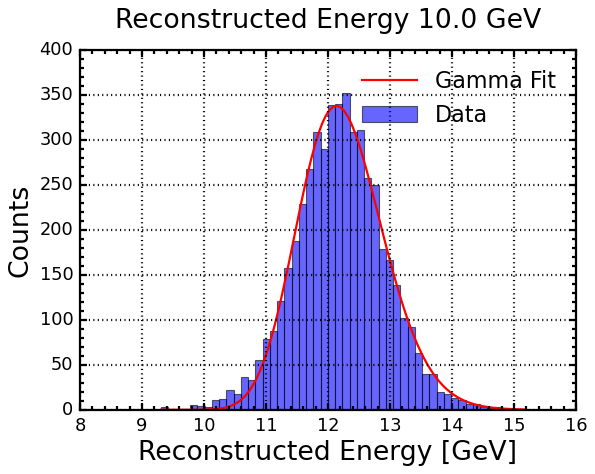

In [12]:
#This cell is left here for debug
print("length of Reco_hist_all:", len(Reco_hist_all))
Reco_hist = Reco_hist_all[0] # Example for first beta
print("length of Reco_hist:", len(Reco_hist))
i_E = 6 # Example index, change as needed
#print(len(Reco_hist))
#print(Reco_hist[i_E])
mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error = fit_all(
    "E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])

Mean: 0.5629200024634414, Peak: 0.5173414945602417, RMS: 0.10610264478645266
Initial Gamma Fit Parameters: [89.00633464753628, 3.53898698691236, 0.18742412, 0.10610264478645266]
Gamma Fit Bounds: lower [0.8900633464753628, -0.646101301308764, -0.9812575876712799, 0.010610264478645267], 
 upper [534.0380078852177, 35.3898698691236, 10.281136184930801, 1.0610264478645266]
Gamma Fit Parameters: [8.47667453e+01 6.36883854e+00 3.31090460e-01 3.54508092e-02]
Gamma Fit Peak: 0.5214201309074361 ± 0.0030698251384713455, Mean: 0.5568709401180121 ± 0.0032944405617362105, Resolution: 0.1715807169465833 ± 0.0059757535951554756


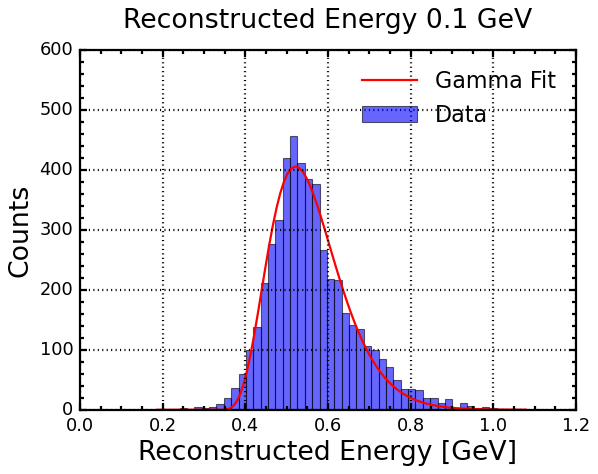

appending results for E = 0.1
Mean_Gamma: 0.5568709401180121 Mean_Gamma_Error: 0.0032944405617362105
Peak_Gamma: 0.5214201309074361 Peak_Gamma_Error: 0.0030698251384713455
Mean: 0.752044642108816, Peak: 0.6866611838340759, RMS: 0.15397781771405553
Initial Gamma Fit Parameters: [113.57784703373909, 2.418210504997726, 0.37969387, 0.15397781771405553]
Gamma Fit Bounds: lower [1.135778470337391, -0.7581789495002274, -0.9620306134223938, 0.015397781771405553], 
 upper [681.4670822024345, 24.18210504997726, 10.569540798664093, 1.5397781771405552]
Gamma Fit Parameters: [1.12438651e+02 5.25507462e+00 4.11302067e-01 6.42525604e-02]
Gamma Fit Peak: 0.6847015059923818 ± 0.002583863782756667, Mean: 0.7489540663471751 ± 0.002821368585894509, Resolution: 0.21511891503973984 ± 0.004139206842407957


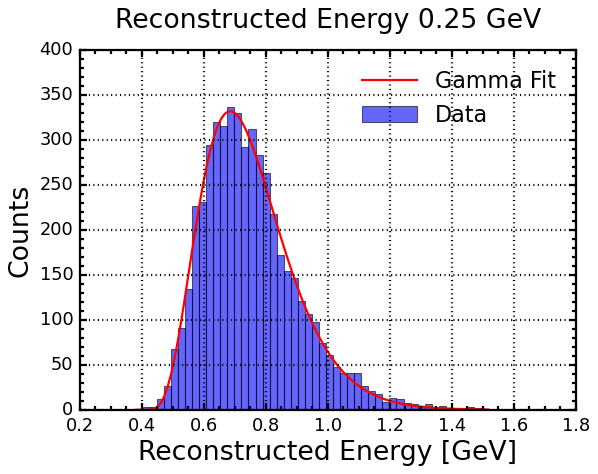

appending results for E = 0.25
Mean_Gamma: 0.7489540663471751 Mean_Gamma_Error: 0.002821368585894509
Peak_Gamma: 0.6847015059923818 Peak_Gamma_Error: 0.002583863782756667
Mean: 1.1555462929487228, Peak: 0.9756836891174316, RMS: 0.2929075314777619
Initial Gamma Fit Parameters: [208.84141325950623, 2.539144419359364, 0.41181177, 0.2929075314777619]
Gamma Fit Bounds: lower [2.0884141325950623, -0.7460855580640635, -0.9588188230991364, 0.02929075314777619], 
 upper [1253.0484795570374, 25.39144419359364, 10.617717653512955, 2.9290753147776187]
Gamma Fit Parameters: [2.07494700e+02 5.90883576e+00 4.55830392e-01 1.17937551e-01]
Gamma Fit Peak: 1.0347664584353717 ± 0.006504902609039825, Mean: 1.1527040091531138 ± 0.007025403444821089, Resolution: 0.2770516372123635 ± 0.006904981918814621


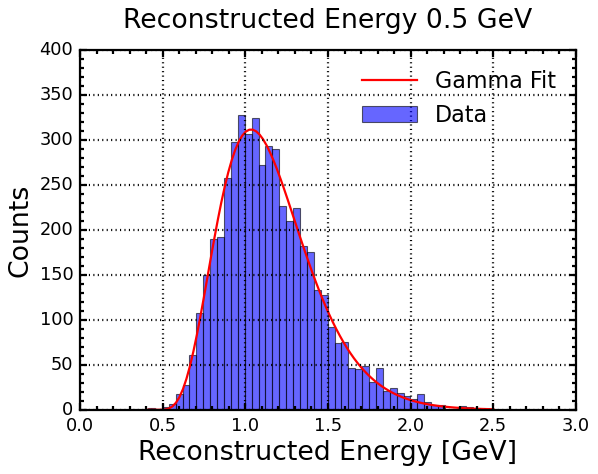

appending results for E = 0.5
Mean_Gamma: 1.1527040091531138 Mean_Gamma_Error: 0.007025403444821089
Peak_Gamma: 1.0347664584353717 Peak_Gamma_Error: 0.006504902609039825
Mean: 2.1368431823730467, Peak: 2.0812182426452637, RMS: 0.4232312275266406
Initial Gamma Fit Parameters: [304.5600652694702, 2.937894269992168, 0.8934346, 0.4232312275266406]
Gamma Fit Bounds: lower [3.045600652694702, -0.7062105730007832, -0.9106565415859222, 0.04232312275266406], 
 upper [1827.3603916168213, 29.37894269992168, 11.340151876211166, 4.232312275266406]
Gamma Fit Parameters: [ 3.03509800e+02  2.93789427e+01 -1.58596090e-01  7.84841421e-02]
Gamma Fit Peak: 2.0687008811409453 ± 0.01041869450277725, Mean: 2.147185023228355 ± 0.010566168018283974, Resolution: 0.2056374913054181 ± 0.003950458268114441


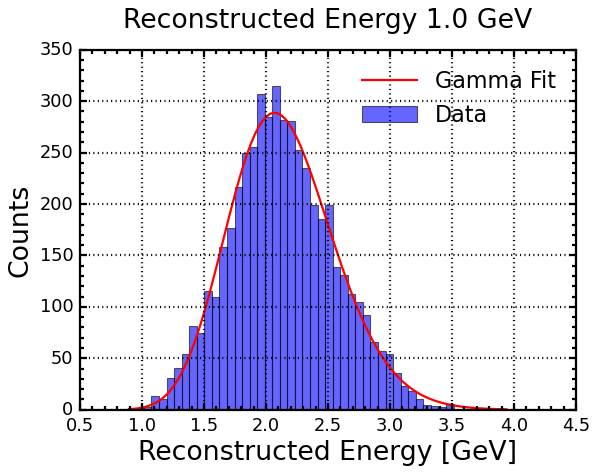

appending results for E = 1.0
Mean_Gamma: 2.147185023228355 Mean_Gamma_Error: 0.010566168018283974
Peak_Gamma: 2.0687008811409453 Peak_Gamma_Error: 0.01041869450277725
Mean: 3.761305085849762, Peak: 3.8282885551452637, RMS: 0.4682048921264038
Initial Gamma Fit Parameters: [345.2765941619873, 3.47042977775514, 2.136433, 0.4682048921264038]
Gamma Fit Bounds: lower [3.452765941619873, -0.652957022224486, -0.7863567113876343, 0.046820489212640384], 
 upper [2071.659564971924, 34.7042977775514, 13.204649329185486, 4.682048921264038]
Gamma Fit Parameters: [3.47031122e+02 3.47042978e+01 9.59331102e-01 8.18929073e-02]
Gamma Fit Peak: 3.719474034306371 ± 0.011707676445761412, Mean: 3.8013669415853126 ± 0.011851451437566732, Resolution: 0.1297049016079125 ± 0.0023205646481878495


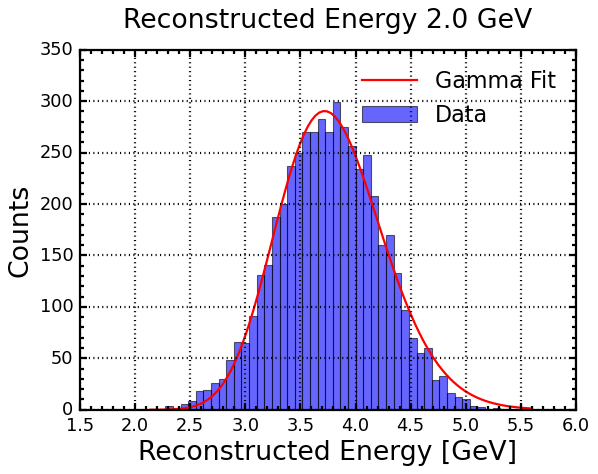

appending results for E = 2.0
Mean_Gamma: 3.8013669415853126 Mean_Gamma_Error: 0.011851451437566732
Peak_Gamma: 3.719474034306371 Peak_Gamma_Error: 0.011707676445761412
Mean: 7.348605624674129, Peak: 7.3419647216796875, RMS: 0.5331310336886613
Initial Gamma Fit Parameters: [452.21104192733765, 4.508909495336615, 4.944766, 0.5331310336886613]
Gamma Fit Bounds: lower [4.5221104192733765, -0.5491090504663385, -0.50552339553833, 0.05331310336886613], 
 upper [2713.266251564026, 45.08909495336616, 17.41714906692505, 5.331310336886613]
Gamma Fit Parameters: [4.52944004e+02 4.50890950e+01 3.75712314e+00 8.04438315e-02]
Gamma Fit Peak: 7.3038188694682225 ± 0.013346826528631917, Mean: 7.384262701002825 ± 0.013470189745791113, Resolution: 0.07395686825955548 ± 0.0012802598788487693


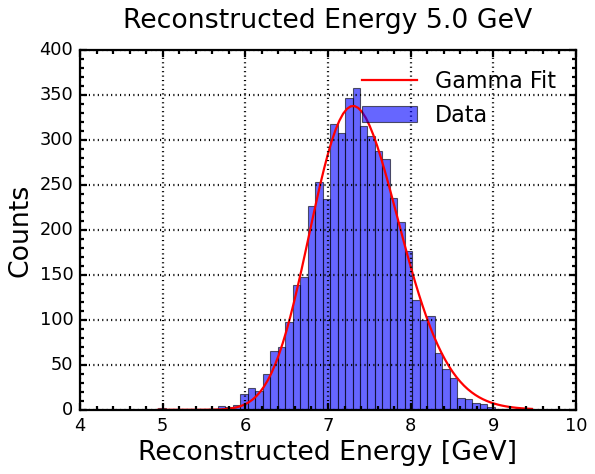

appending results for E = 5.0
Mean_Gamma: 7.384262701002825 Mean_Gamma_Error: 0.013470189745791113
Peak_Gamma: 7.3038188694682225 Peak_Gamma_Error: 0.013346826528631917
Mean: 12.19390565025754, Peak: 12.290260314941406, RMS: 0.7226765510600177
Initial Gamma Fit Parameters: [584.6402034759521, 3.9941786135824735, 9.307406, 0.7226765510600177]
Gamma Fit Bounds: lower [5.846402034759522, -0.6005821386417527, -0.06925935745239253, 0.07226765510600178], 
 upper [3507.841220855713, 39.941786135824735, 23.96110963821411, 7.226765510600178]
Gamma Fit Parameters: [5.76382813e+02 3.99417861e+01 7.89614938e+00 1.08894405e-01]
Gamma Fit Peak: 12.13669199945884 ± 0.015052576991228611, Mean: 12.245586404057551 ± 0.01520760729985267, Resolution: 0.05670468926720571 ± 0.0008705458875971731


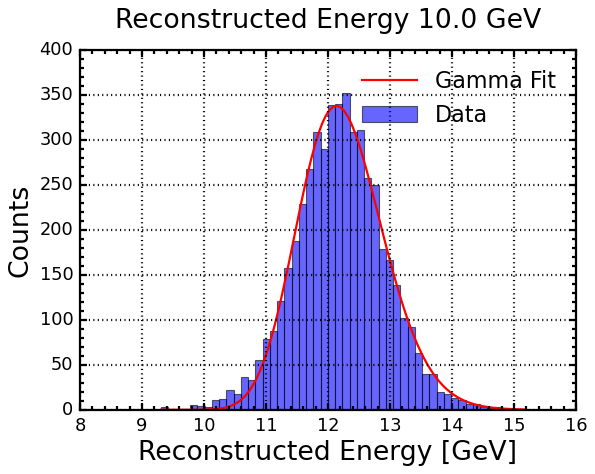

appending results for E = 10.0
Mean_Gamma: 12.245586404057551 Mean_Gamma_Error: 0.01520760729985267
Peak_Gamma: 12.13669199945884 Peak_Gamma_Error: 0.015052576991228611
Mean: 21.07904720649788, Peak: 20.683250427246094, RMS: 1.3857616879884285
Initial Gamma Fit Parameters: [1319.4973239898682, 4.571286675186868, 14.744333, 1.3857616879884285]
Gamma Fit Bounds: lower [13.194973239898681, -0.5428713324813133, 0.47443332672119154, 0.13857616879884285], 
 upper [7916.983943939209, 45.71286675186868, 32.11649990081787, 13.857616879884285]
Gamma Fit Parameters: [1.31217988e+03 4.11717754e+01 1.24120206e+01 2.10634476e-01]
Gamma Fit Peak: 20.873581486116404 ± 0.022171590362045, Mean: 21.08421596178379 ± 0.022392010333220715, Resolution: 0.06474888317546673 ± 0.0007463592090206479


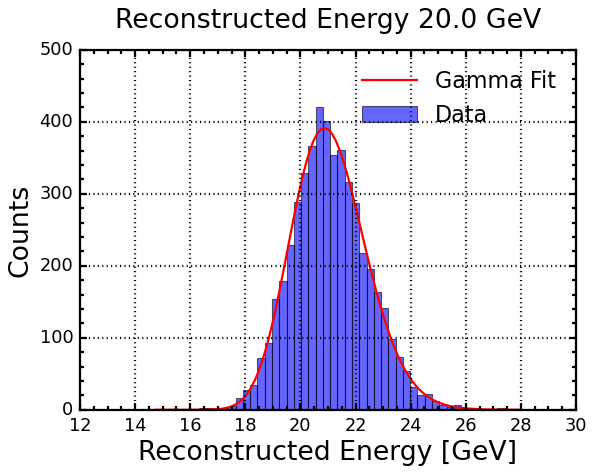

appending results for E = 20.0
Mean_Gamma: 21.08421596178379 Mean_Gamma_Error: 0.022392010333220715
Peak_Gamma: 20.873581486116404 Peak_Gamma_Error: 0.022171590362045
Mean: 30.67616519702596, Peak: 30.721025466918945, RMS: 1.9479630818708211
Initial Gamma Fit Parameters: [1684.288013458252, 4.0464789190628165, 22.793774, 1.9479630818708211]
Gamma Fit Bounds: lower [16.84288013458252, -0.5953521080937183, 1.2793773651123046, 0.19479630818708213], 
 upper [10105.728080749512, 40.46478919062817, 44.19066047668457, 19.479630818708213]
Gamma Fit Parameters: [1.67216055e+03 2.42720404e+01 2.13985821e+01 3.82250239e-01]
Gamma Fit Peak: 30.29432503856875 ± 0.029951323063902018, Mean: 30.67657527730688 ± 0.030464288358673843, Resolution: 0.0621640966969086 ± 0.0007314034199023398


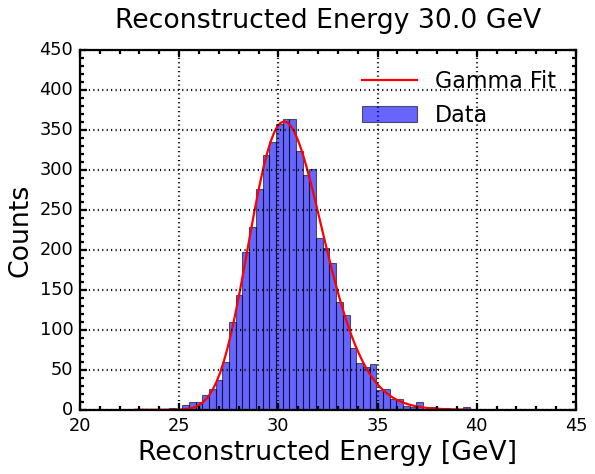

appending results for E = 30.0
Mean_Gamma: 30.67657527730688 Mean_Gamma_Error: 0.030464288358673843
Peak_Gamma: 30.29432503856875 Peak_Gamma_Error: 0.029951323063902018
Mean: 40.579327294557885, Peak: 40.62510681152344, RMS: 2.312715491253278
Initial Gamma Fit Parameters: [1964.1718940734863, 4.144245979812902, 30.994865, 2.312715491253278]
Gamma Fit Bounds: lower [19.641718940734865, -0.5855754020187098, 2.099486541748047, 0.2312715491253278], 
 upper [11785.031364440918, 41.442459798129015, 56.4922981262207, 23.12715491253278]
Gamma Fit Parameters: [1.94195073e+03 4.14424598e+01 2.64517283e+01 3.40607931e-01]
Gamma Fit Peak: 40.22675082599051 ± 0.04565742674034271, Mean: 40.567358757464255 ± 0.04610821720506477, Resolution: 0.054508290758305954 ± 0.0007935376018526205


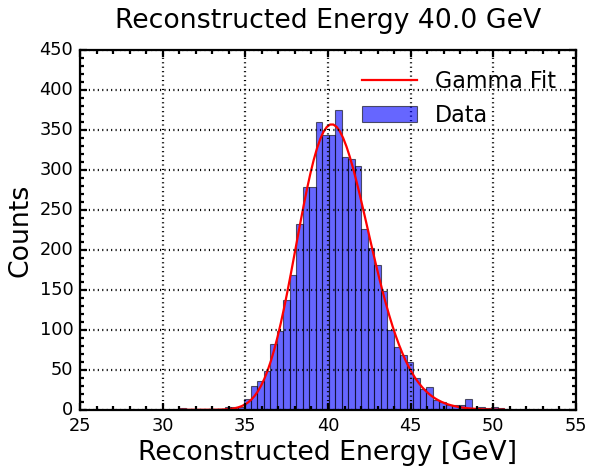

appending results for E = 40.0
Mean_Gamma: 40.567358757464255 Mean_Gamma_Error: 0.04610821720506477
Peak_Gamma: 40.22675082599051 Peak_Gamma_Error: 0.04565742674034271
Mean: 50.47505593652866, Peak: 50.34283447265625, RMS: 2.4884053279689544
Initial Gamma Fit Parameters: [2133.6600494384766, 3.913165323684172, 40.737514, 2.4884053279689544]
Gamma Fit Bounds: lower [21.336600494384765, -0.6086834676315828, 3.073751449584961, 0.24884053279689544], 
 upper [12801.96029663086, 39.13165323684172, 71.10627174377441, 24.884053279689546]
Gamma Fit Parameters: [2.09986830e+03 3.91316532e+01 3.59418551e+01 3.73950959e-01]
Gamma Fit Peak: 50.201223385769694 ± 0.053012110959771194, Mean: 50.57517434475635 ± 0.05356583458091271, Resolution: 0.046597696522862 ± 0.0007392409795608325


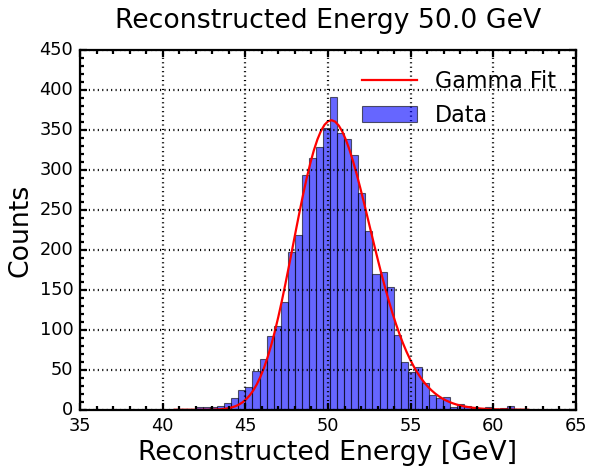

appending results for E = 50.0
Mean_Gamma: 50.57517434475635 Mean_Gamma_Error: 0.05356583458091271
Peak_Gamma: 50.201223385769694 Peak_Gamma_Error: 0.053012110959771194
Mean: 60.21074825117425, Peak: 60.449588775634766, RMS: 2.6944413781207848
Initial Gamma Fit Parameters: [2291.182159423828, 3.9095479102537083, 49.6767, 2.6944413781207848]
Gamma Fit Bounds: lower [22.911821594238283, -0.6090452089746292, 3.967670059204102, 0.2694441378120785], 
 upper [13747.092956542969, 39.095479102537084, 84.51505088806152, 26.94441378120785]
Gamma Fit Parameters: [2.25791141e+03 3.90954791e+01 4.43026737e+01 4.11172944e-01]
Gamma Fit Peak: 59.96650404298502 ± 0.06287081153327721, Mean: 60.37767698702916 ± 0.06352940200330041, Resolution: 0.042872525614254316 ± 0.0007328741195362613


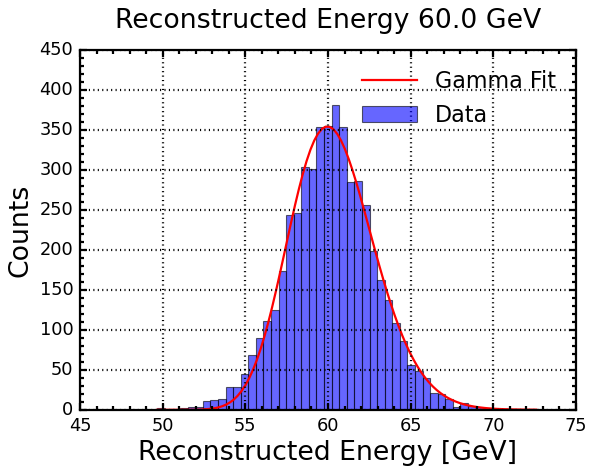

appending results for E = 60.0
Mean_Gamma: 60.37767698702916 Mean_Gamma_Error: 0.06352940200330041
Peak_Gamma: 59.96650404298502 Peak_Gamma_Error: 0.06287081153327721


In [13]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
def OutputCSV(Reco_hist, Energy_test, CSV_name):
    results = []
    for i_E in range(len(Energy_test)):
        mean_gauss,mean_gauss_error,peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0, 0, 0
        mean_log_normal,mean_log_normal_error,peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0, 0, 0
        mean_gamma,mean_gamma_error,peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])
        print("appending results for E =", Energy_test[i_E])
        print("Mean_Gamma:", mean_gamma, "Mean_Gamma_Error:", mean_gamma_error)
        print("Peak_Gamma:", peak_gamma, "Peak_Gamma_Error:", peak_gamma_error)
        results.append({
            "ParticleEnergy": Energy_test[i_E],
            "Mean_Gauss": mean_gauss,
            "Mean_Gauss_Error": mean_gauss_error,
            "Peak_Gauss": peak_gauss,
            "Peak_Gauss_Error": peak_gauss_error,
            "Res_Gauss": res_gauss,
            "Res_Gauss_Error": res_gauss_error,
            "Mean_Gamma": mean_gamma,
            "Mean_Gamma_Error": mean_gamma_error,
            "Peak_Gamma": peak_gamma,
            "Peak_Gamma_Error": peak_gamma_error,
            "Res_Gamma": res_gamma,
            "Res_Gamma_Error": res_gamma_error,
            "Mean_LogNormal": mean_log_normal,
            "Mean_LogNormal_Error": mean_log_normal_error,
            "Peak_LogNormal": peak_log_normal,
            "Peak_LogNormal_Error": peak_log_normal_error,
            "Res_LogNormal": res_log_normal,
            "Res_LogNormal_Error": res_log_normal_error
        })
    df = pd.DataFrame(results)
    df.to_csv(CSV_name, index=False)
outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_DGCNN3_Fit.csv")
OutputCSV(Reco_hist_all[0], Energy_test, outputfile_name)
# for i_para, para in enumerate(ParameterScan):
#     if i_para != 0:
#         continue  # 
#     #outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_LR{para:.0e}_Fit.csv")
#     outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_Fit.csv")
#     OutputCSV(Reco_hist_mlp_all[i_para], Energy_test, outputfile_name)
#     print(f"Saved fit results to {outputfile_name}")